# Decision Tree & Random Forest for BOM Data

## Import Packages

In [65]:
import numpy as np
import pandas as pd
import datetime
import random
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")                 

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
import shap

In [67]:
import os
os.getcwd()

'/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Group/Energy-Usage-Prediction-Project/Zheyu/Used Data'

## Read Data

In [68]:
os.chdir('/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Group/Energy-Usage-Prediction-Project/Zheyu/Used Data')

In [69]:
df = pd.read_csv('processedData_final_final.csv', index_col = 0)
df.head(100)

,Operational Demand (MW),Transpiration,Rain,Evaporation,Max Temp,Min Temp,Max Hum,Min Hum,Av Wind,Solar Rad,...,sin_month,cos_month,sin_Day_of_week,cos_Day_of_week,sin_Day_of_month,cos_Day_of_month,sin_Day_of_year,cos_Day_of_year,sin_week_of_year,cos_week_of_year
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,95141.184,11.2,0.0,11.6,37.2,18.8,65.0,20.0,6.10,34.01,...,0.500000,0.866025,0.433884,-0.900969,0.207912,0.978148,0.017213,0.999852,0.120537,0.992709
2009-01-02,108058.504,10.2,0.0,12.8,36.1,21.9,70.0,25.0,5.31,34.25,...,0.500000,0.866025,-0.433884,-0.900969,0.406737,0.913545,0.034422,0.999407,0.120537,0.992709
2009-01-03,95788.860,9.4,0.0,11.8,34.4,20.3,79.0,29.0,5.45,34.11,...,0.500000,0.866025,-0.974928,-0.222521,0.587785,0.809017,0.051620,0.998667,0.120537,0.992709
2009-01-04,93777.404,10.5,0.0,11.2,36.5,18.5,62.0,20.0,5.25,34.05,...,0.500000,0.866025,-0.781831,0.623490,0.743145,0.669131,0.068802,0.997630,0.120537,0.992709
2009-01-05,112678.424,11.9,0.0,11.4,37.2,21.8,63.0,17.0,6.77,34.18,...,0.500000,0.866025,0.000000,1.000000,0.866025,0.500000,0.085965,0.996298,0.239316,0.970942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-04-06,91199.480,7.6,0.0,8.4,29.2,14.7,64.0,17.0,6.36,22.32,...,0.866025,-0.500000,0.000000,1.000000,0.951057,0.309017,0.996659,-0.081676,0.970942,-0.239316
2009-04-07,94116.376,7.1,0.0,7.4,31.6,17.2,52.0,16.0,4.54,22.04,...,0.866025,-0.500000,0.781831,0.623490,0.994522,0.104528,0.995105,-0.098820,0.970942,-0.239316
2009-04-08,96776.066,7.3,0.0,7.4,33.6,17.4,55.0,11.0,4.44,20.64,...,0.866025,-0.500000,0.974928,-0.222521,0.994522,-0.104528,0.993257,-0.115935,0.970942,-0.239316


## Data Cleaning

In [70]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in df.columns:
    if df[i].dtype not in numeric_dtypes:
        df[i]=df[i].str.replace(" ",'') # Replace all ' ' into none
        df[i]=pd.to_numeric(df[i])

In [71]:
df.index = pd.to_datetime(df.index,format= '%Y-%m-%d')
# df.index = pd.to_datetime(df.index,format= '%d/%m/%Y')
select_col=['Operational Demand (MW)', 'Transpiration', 'Rain', 'Evaporation',
       'Max Temp', 'Min Temp', 'Max Hum', 'Min Hum', 'Av Wind', 'Solar Rad',
       'state_holiday', 'sin_month', 'cos_month', 'sin_Day_of_week',
       'cos_Day_of_week', 'sin_Day_of_month', 'cos_Day_of_month',
       'sin_Day_of_year', 'cos_Day_of_year', 'sin_week_of_year',
       'cos_week_of_year']
y_col=['Operational Demand (MW)']
x_col=list(set(select_col)-set(y_col))

model_df=df[select_col].fillna(method='ffill',axis=0)
test_dat = model_df[(model_df.index >= '2021-12-01') & ('2022-04-01' > model_df.index)]
training_dat = model_df[model_df.index < '2021-12-01']

# training_dat = model_df[(model_df.index < '2021-12-01') | ('2022-04-01' <= model_df.index)]

In [72]:
X_train = training_dat.drop('Operational Demand (MW)',axis=1)
y_train = training_dat['Operational Demand (MW)']

X_test = test_dat.drop('Operational Demand (MW)', axis = 1) 
y_test = test_dat['Operational Demand (MW)']

## Function Create

In [73]:
def ImportanceDisplay(model):
    if 'grid' in model:
        impo_lst=[model,'.best_estimator_.feature_importances_']
    else:
        impo_lst=[model,'.feature_importances_']
    impo_str=''
    importance = eval(impo_str.join(impo_lst))
    #importance = rf_reg.feature_importances_
    table = PrettyTable(['Factors','Score'])
    for i,v in enumerate(importance):
	    table.add_row([x_col[i],round(v,4)])
    print(table)
def ModelScore(true,predict):
    print("Mean absolute error = ",round(sm.mean_absolute_error(true,predict),4))
    print("Mean squared error = ",round(sm.mean_squared_error(true,predict),4))
    print("Median absolute error = ",round(sm.median_absolute_error(true,predict),4))
    print("explained variance error = ",round(sm.explained_variance_score(true,predict),4))
    print("R2 error = ",round(sm.r2_score(true,predict),4))

## Threshold Determine

125225.874

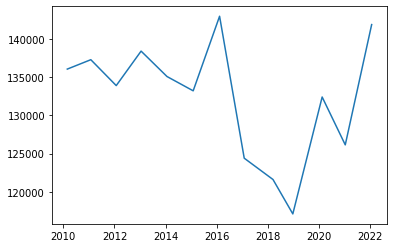

In [99]:
new_df_summer = pd.DataFrame()
for i in range(2009,2022):
    s0 = str(i) + '-12-01'
    s1 = str(i+1) + '-04-01'
    df_summer = model_df[(model_df.index >= s0) & (s1 > model_df.index)]
    order_table = df_summer.sort_values('Operational Demand (MW)',ascending=False)
    nr = order_table[3:4]
    new_df_summer = pd.concat((new_df_summer,nr))
od = new_df_summer['Operational Demand (MW)']
plt.plot(od.index,od)
year_choose = 3 # number of year we choose to get the average threshold
ave_threshold = sum(od[-4:-1])/year_choose
# ave_threshold= sum(od[:-1])/len(od[:-1])
ave_threshold


In [75]:
od

Date
2010-02-26    136032.698
2011-01-28    137258.610
2012-01-26    133880.634
2013-01-15    138378.508
2014-01-20    135063.762
2015-01-29    133198.826
2016-02-10    142928.122
2017-01-27    124407.598
2018-03-14    121625.992
2018-12-22    117137.326
2020-02-14    132391.970
2021-01-09    126148.326
2022-01-21    141839.600
Name: Operational Demand (MW), dtype: float64

## Decision Tree

In [76]:
tree_reg = DecisionTreeRegressor(random_state=42)

param_grid_dtree = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_dtree=GridSearchCV(tree_reg, param_grid_dtree, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_dtree.fit(X_train,y_train)
y_pred_tree_test = grid_dtree.predict(X_test)
print(grid_dtree.best_estimator_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.0s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.0s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.0s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.0s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.0s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.0s
[CV] END ...................max_depth=15, min_sa

In [77]:
tree_model = DecisionTreeRegressor(min_samples_leaf=50, random_state=42)
tree_model.fit(X_train,y_train)
y_pred_tree = tree_model.predict(X_test)

In [78]:
dtscore=ModelScore(y_test,y_pred_tree)
dtscore
ny_test=len(y_test)
mape = (sum(np.abs((y_test - y_pred_tree)/y_test))/ny_test)*100
print('Mape', mape)
ImportanceDisplay('tree_model')

Mean absolute error =  6450.0233
Mean squared error =  65872878.6525
Median absolute error =  5552.3013
explained variance error =  0.7762
R2 error =  0.7757
Mape 6.125247161114825
+------------------+--------+
|     Factors      | Score  |
+------------------+--------+
|  state_holiday   |  0.0   |
| cos_week_of_year | 0.0024 |
| sin_Day_of_year  | 0.0027 |
| cos_Day_of_year  | 0.4811 |
|     Max Temp     | 0.1955 |
| sin_Day_of_week  | 0.0022 |
|     Min Hum      | 0.0053 |
|    sin_month     | 0.0024 |
|   Evaporation    | 0.0385 |
|     Min Temp     |  0.0   |
| cos_Day_of_week  |  0.0   |
| sin_week_of_year |  0.0   |
|     Av Wind      | 0.1786 |
| cos_Day_of_month |  0.0   |
|     Max Hum      | 0.0004 |
|  Transpiration   | 0.0008 |
|    Solar Rad     | 0.009  |
|    cos_month     | 0.0806 |
| sin_Day_of_month |  0.0   |
|       Rain       | 0.0007 |
+------------------+--------+


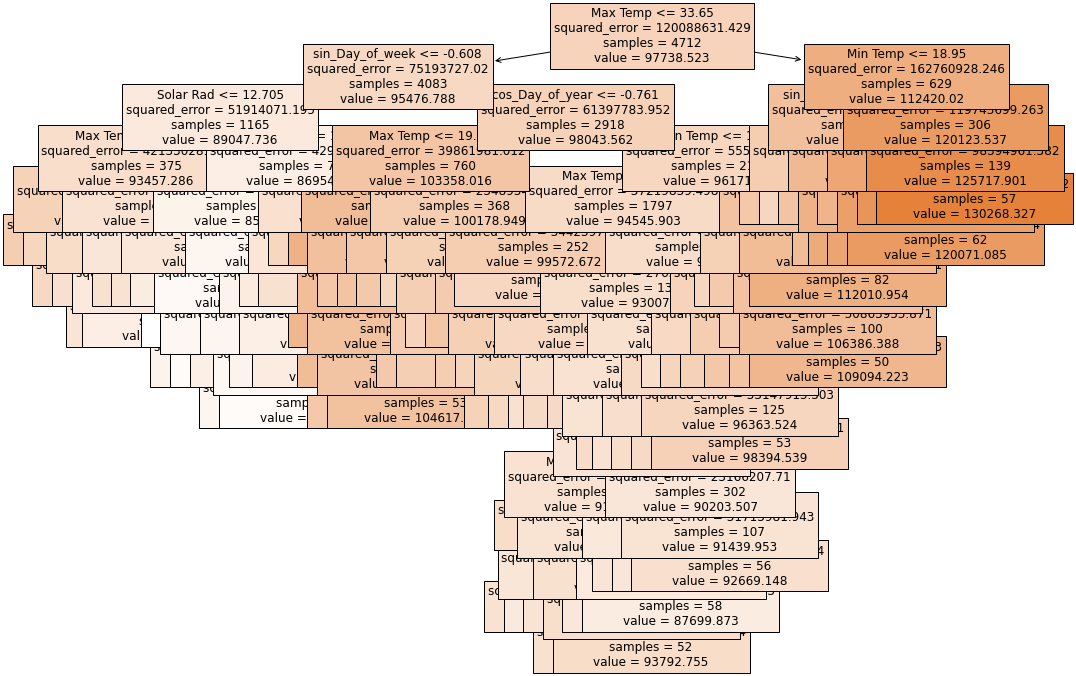

In [79]:
fig = plt.figure(figsize=(16,12))
a_rf_smote = plot_tree(tree_model, feature_names=X_train.columns, fontsize=12, filled=True, class_names=['0', '1'])

In [80]:
y_pred_tree = pd.DataFrame(y_pred_tree)
predict_table_dt = pd.DataFrame(y_test)
predict_table_dt.insert(1,'predict',y_pred_tree)
predict_table_dt

,Operational Demand (MW),predict
Date,,
2021-12-01,81389.002,90090.248157
2021-12-02,83692.208,92669.147571
2021-12-03,87674.768,97058.771170
2021-12-04,86230.014,92306.394576
2021-12-05,83724.146,96667.727529
...,...,...
2022-03-27,94461.504,92118.711321
2022-03-28,96458.404,101111.504941
2022-03-29,102975.830,109094.223200


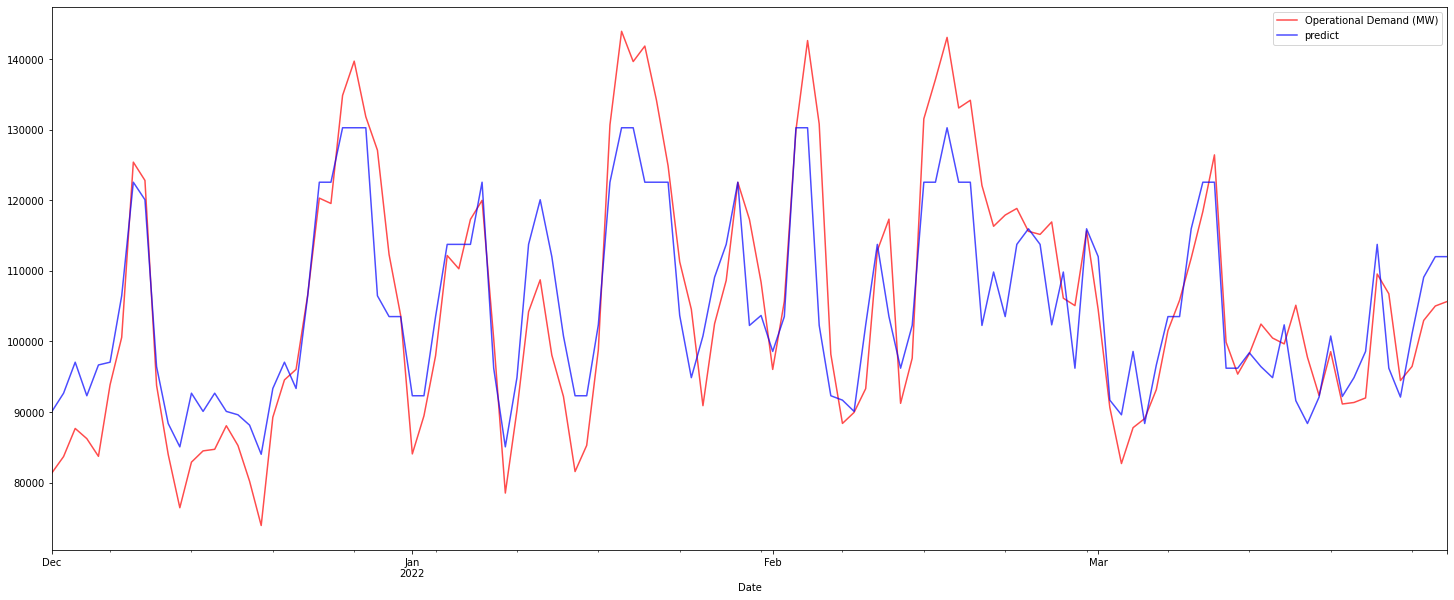

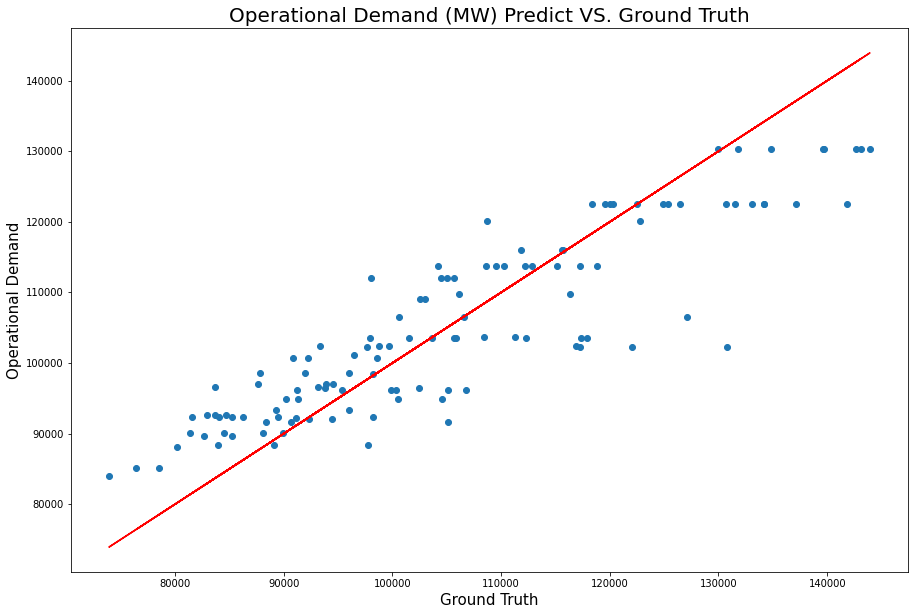

In [81]:
predict_table_dt.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_dt['Operational Demand (MW)'], predict_table_dt['predict'])
plt.plot(predict_table_dt['Operational Demand (MW)'],predict_table_dt['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [100]:
peak_day = 5 # number of top peak day we choose
peak_true_tree = predict_table_dt.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true_tree.index.tolist()
# peak_predict = predict_table_dt.sort_values('predict',ascending=False)[:peak_day]
peak_predict_tree = predict_table_dt[predict_table_dt['predict'] > ave_threshold]
predictlst=peak_predict_tree.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 0.8


In [101]:
peak_true_tree

,Operational Demand (MW),predict
Date,,
2022-01-19,143929.714,130268.326807
2022-02-16,143068.538,130268.326807
2022-02-04,142620.646,130268.326807
2022-01-21,141839.600,122554.800927
2021-12-27,139702.954,130268.326807


In [102]:
peak_predict_tree

,Operational Demand (MW),predict
Date,,
2021-12-26,134848.128,130268.326807
2021-12-27,139702.954,130268.326807
2021-12-28,131818.396,130268.326807
2022-01-19,143929.714,130268.326807
2022-01-20,139644.016,130268.326807
2022-02-03,129938.672,130268.326807
2022-02-04,142620.646,130268.326807
2022-02-16,143068.538,130268.326807


## Random Forest

In [85]:
forest = RandomForestRegressor(random_state=42)

param_grid_forest = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_forest=GridSearchCV(forest, param_grid_forest, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_forest.fit(X_train, y_train)
y_predict_forest_test = grid_forest.predict(X_test)
print(grid_forest.best_estimator_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   1.5s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   1.6s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   1.6s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.9s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.9s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.9s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.8s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.8s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.8s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   1.5s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   1.5s
[CV] END ...................max_depth=15, min_sa

In [86]:
forest_model = RandomForestRegressor(max_depth=15, min_samples_leaf=5, random_state=42)
forest_model.fit(X_train,y_train)
y_predict_forest = forest_model.predict(X_test)

In [87]:
rfscore=ModelScore(y_test,y_predict_forest)
rfscore
mape = (sum(np.abs((y_test - y_predict_forest)/y_test))/ny_test)*100
print('Mape', mape)
ImportanceDisplay('forest_model')

Mean absolute error =  5716.4529
Mean squared error =  46117287.3045
Median absolute error =  5382.1152
explained variance error =  0.8436
R2 error =  0.843
Mape 5.525821838576148
+------------------+--------+
|     Factors      | Score  |
+------------------+--------+
|  state_holiday   | 0.0069 |
| cos_week_of_year | 0.0036 |
| sin_Day_of_year  | 0.0118 |
| cos_Day_of_year  | 0.3788 |
|     Max Temp     | 0.235  |
| sin_Day_of_week  | 0.0087 |
|     Min Hum      | 0.011  |
|    sin_month     | 0.0146 |
|   Evaporation    | 0.037  |
|     Min Temp     | 0.0139 |
| cos_Day_of_week  | 0.0011 |
| sin_week_of_year | 0.0017 |
|     Av Wind      | 0.1557 |
| cos_Day_of_month | 0.0031 |
|     Max Hum      | 0.0077 |
|  Transpiration   | 0.0062 |
|    Solar Rad     | 0.0168 |
|    cos_month     | 0.0745 |
| sin_Day_of_month | 0.0051 |
|       Rain       | 0.0065 |
+------------------+--------+


In [88]:
y_predict_forest = pd.DataFrame(y_predict_forest)
predict_table_rf = pd.DataFrame(y_test)
predict_table_rf.insert(1,'predict',y_predict_forest)
predict_table_rf

,Operational Demand (MW),predict
Date,,
2021-12-01,81389.002,89537.651881
2021-12-02,83692.208,93783.573446
2021-12-03,87674.768,97402.457677
2021-12-04,86230.014,91980.477296
2021-12-05,83724.146,96833.780176
...,...,...
2022-03-27,94461.504,95714.203904
2022-03-28,96458.404,96830.286065
2022-03-29,102975.830,104686.996213


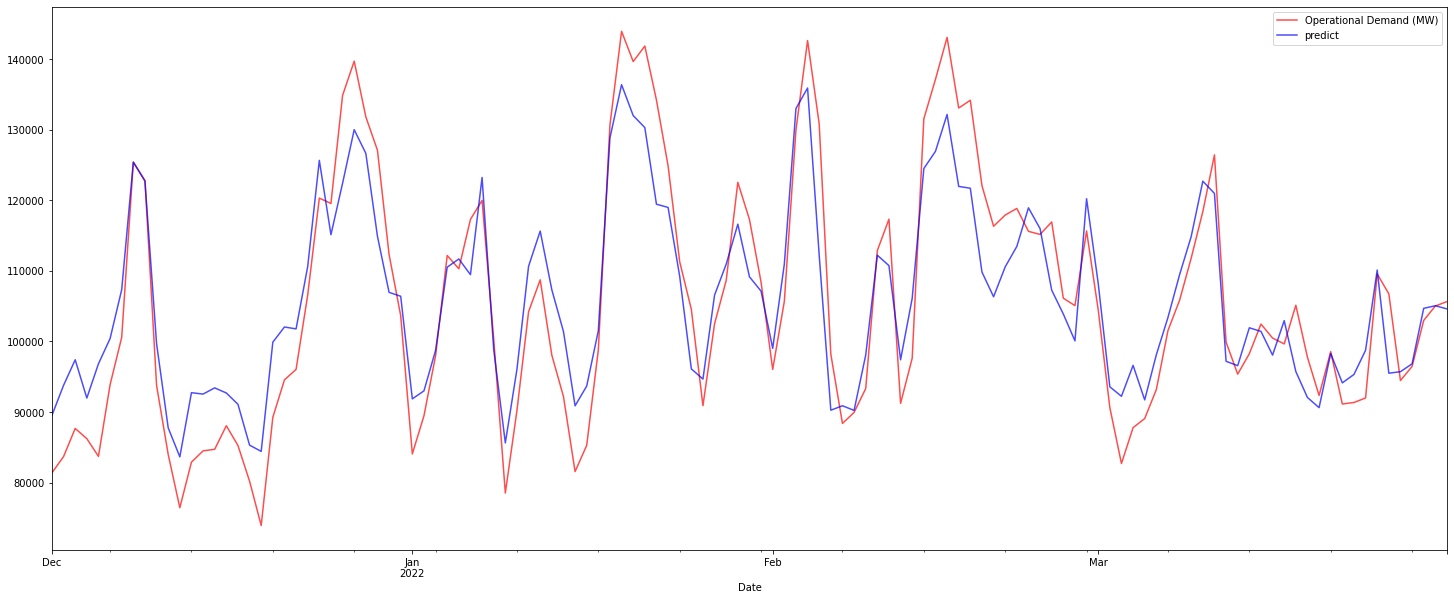

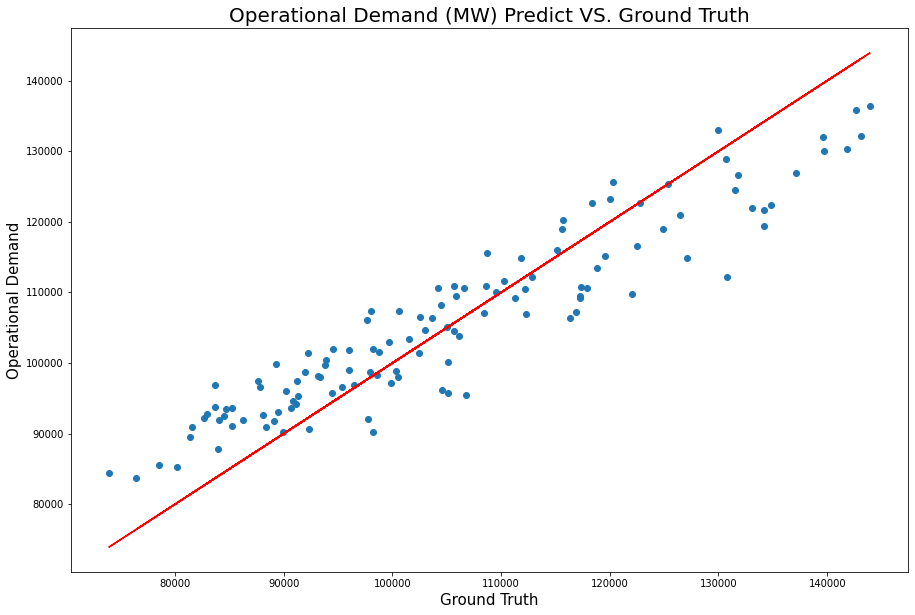

In [89]:
predict_table_rf.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_rf['Operational Demand (MW)'], predict_table_rf['predict'])
plt.plot(predict_table_rf['Operational Demand (MW)'],predict_table_rf['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [90]:
# peak_day = predict_table[predict_table['predict'] >= ave_threshold]
# peak_day

In [103]:
peak_day = 5 # number of top peak day we choose
peak_true = predict_table_rf.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true.index.tolist()
# peak_predict = predict_table_rf.sort_values('predict',ascending=False)[:peak_day]
peak_predict = predict_table_rf[predict_table_rf['predict'] > ave_threshold]
predictlst=peak_predict.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 1.0


In [104]:
peak_true

,Operational Demand (MW),predict
Date,,
2022-01-19,143929.714,136371.617018
2022-02-16,143068.538,132147.260637
2022-02-04,142620.646,135896.589561
2022-01-21,141839.600,130292.162753
2021-12-27,139702.954,129996.257821


In [105]:
peak_predict

,Operational Demand (MW),predict
Date,,
2021-12-08,125399.196,125400.559866
2021-12-24,120300.800,125646.807112
2021-12-27,139702.954,129996.257821
2021-12-28,131818.396,126644.412299
2022-01-18,130673.158,128837.656229
2022-01-19,143929.714,136371.617018
2022-01-20,139644.016,131990.507902
2022-01-21,141839.600,130292.162753
2022-02-03,129938.672,132994.612224


## SHAP Explain

In [94]:
shap.initjs()
row_choose = 3
explainer = shap.TreeExplainer(forest_model)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[row_choose], X_test.iloc[row_choose])

In [95]:
shap.force_plot(explainer.expected_value, shap_values,X_test)

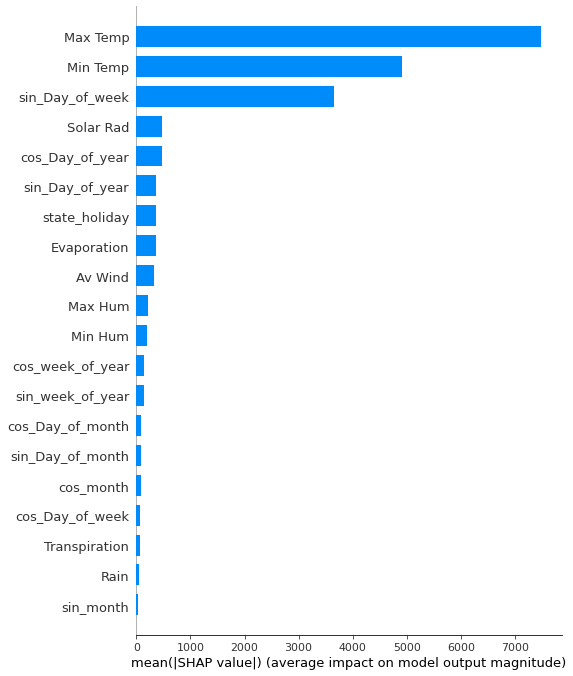

In [96]:
shap_values = shap.TreeExplainer(forest_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

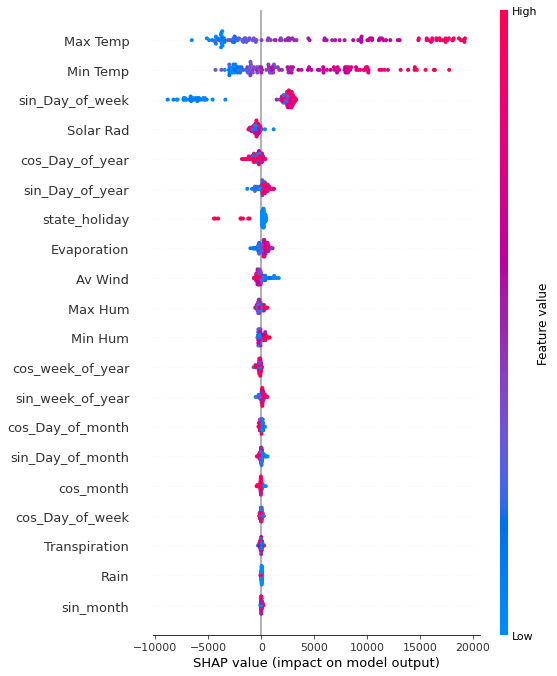

In [97]:
shap.summary_plot(shap_values, X_test)

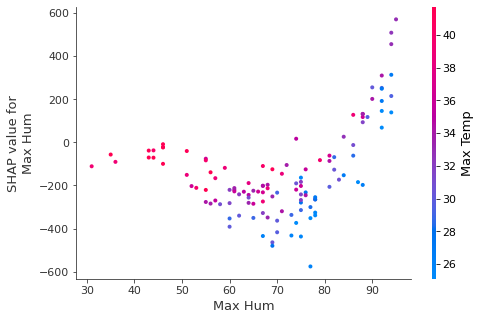

In [98]:
# Part
shap.dependence_plot('Max Hum', shap_values, X_test)